In [51]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import geatpy as ea
from scipy.signal import convolve2d
import seaborn as sns
import scipy.stats as st 
plt.rcParams.update({'font.size': 15})

In [73]:
with open('data/training_set_ip_temp_20Hz_tau7_active_sub.p', 'rb') as fo:
        X_train = pickle.load(fo, encoding='bytes')
with open('data/training_set_op_temp_20Hz_tau7_active_sub.p', 'rb') as fo:
        Y_train = pickle.load(fo, encoding='bytes')
with open('data/testing_set_ip_temp_20Hz_tau7_active_sub.p', 'rb') as fo:
        X_test = pickle.load(fo, encoding='bytes')
with open('data/testing_set_op_temp_20Hz_tau7_active_sub.p', 'rb') as fo:
        Y_test = pickle.load(fo, encoding='bytes')

In [74]:
# delete the spike case
Y_train = np.delete(Y_train, 76, 0)

In [75]:
# standardization
Y_train_std = np.empty_like(Y_train)
Y_test_std = np.empty_like(Y_test)
Y_train_std = (Y_train - np.mean(Y_train)) / np.std(Y_train)
Y_test_std = (Y_test - np.mean(Y_train)) / np.std(Y_train)

In [76]:
# change the input from list to array
Nsyn = 9
time_dur = Y_train.shape[1]
def list2array(X):
    ip_dim = Nsyn
    ip_num = int(len(X) / ip_dim)
    X_array = np.zeros((ip_num, ip_dim, time_dur))
    for i in range(ip_num):
        for j in range(ip_dim):
            for spike_time in X[i*9+j]:
                if spike_time <= 1000:
                    X_array[i,j,int(spike_time)] += 1
    return X_array

X_train_array = list2array(X_train)
X_test_array = list2array(X_test)
X_train_array = np.delete(X_train_array, 76, 0)

In [77]:
def kernel2(tau):
    T = np.arange(time_dur)
    #y = np.heaviside(T - np.exp(delay), 0) * ((T - np.exp(delay)) / tau) * np.exp(-((T - np.exp(delay)) / tau))
    y = np.heaviside(T, 0) * (T / tau) * np.exp(-(T / tau))
    return y

def sigmoid(X, c, theta):
    y = c / (1 + np.exp(-(X - theta)))
    return y

def model_non(X, Omega, Tau, v0, c, theta):
    # X is one sample here
    Y = np.zeros(time_dur)
    for j in range(Nsyn):
        ker = kernel2(Tau[j])
        Y += Omega[j]*np.convolve(X[j], ker)[:time_dur]
    return sigmoid(Y, c, theta) + v0

def hlm_non(X, Omega, Tau, v0, c, theta):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_non(X[i], Omega, Tau, v0, c, theta)
    return Y

In [78]:
def kernel(tau_rise, tau_decay):
    T = np.arange(time_dur)
    y = (1 - np.exp(-T / tau_rise)) * np.exp(-T / tau_decay)
    return y

def sigmoid(X, c, theta):
    y = c / (1 + np.exp(-(X - theta)))
    return y

def model(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    L = np.zeros((Nsyn, time_dur))
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        L[i] = Omega[i]*np.convolve(X[i], ker)[:time_dur]
        Y += L[i]
        if i > 0:
            for j in range(i):
                Y += -K[int(i*(i-1)/2)+j] * L[i] * L[j]
    return Y + v0

def hlm(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model(X[i], Omega, Tau_rise, Tau_decay, K, v0)
    return Y

def model_non2(X, Omega, Tau_rise, Tau_decay, v0, c, theta):
    # X is one sample here
    Y = np.zeros(time_dur)
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        Y += Omega[i]*np.convolve(X[i], ker)[:time_dur]
    return sigmoid(Y, c, theta) + v0

def hlm_non2(X, Omega, Tau_rise, Tau_decay, v0, c, theta):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_non2(X[i], Omega, Tau_rise, Tau_decay, v0, c, theta)
    return Y

def model_l(X, Omega, Tau_rise, Tau_decay, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        Y += Omega[i]*np.convolve(X[i], ker)[:time_dur]
    return Y + v0

def hlm_l(X, Omega, Tau_rise, Tau_decay, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_l(X[i], Omega, Tau_rise, Tau_decay, v0)
    return Y


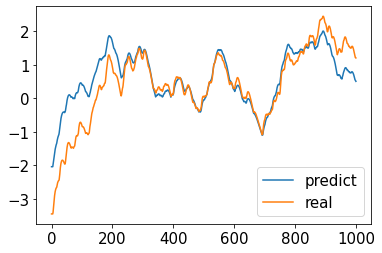

In [18]:
Vars = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
                 0, 0, 0, 0, 0, 0, 0, 0, 0,
                 20, 20, 20, 20, 20, 20, 20, 20, 20,
                 -20, 30, -0.4])# + np.random.random(28)
y = model(X_test_array[-1], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27], Vars[28], Vars[29])
plt.plot(y, label='predict')
plt.plot(Y_test_std[-1], label='real')
plt.legend()

In [19]:
Z = np.zeros(9)
def evalVars(Vars):
    y = hlm(X_train_array, Vars[0:9], Z, Vars[18:27], Vars[27], Vars[28], Vars[29])
    #y = model(X_train_array[1], Vars[0:9], Z, Vars[18:27], Vars[27], Vars[28], Vars[29])
    f = np.mean(np.square(y - Y_train_std))
    return f

In [23]:
res = minimize(evalVars, Vars, method='BFGS', options={'disp': True, 'maxiter': 100})
#res = minimize(evalVars, Vars, method='BFGS', options={'disp': True})
# with open('pars/pars_nonlinear_active_tau7.p', 'wb') as f:
#     pickle.dump(res.x, f)

         Current function value: 0.126431
         Iterations: 100
         Function evaluations: 3689
         Gradient evaluations: 119


In [79]:
# with open('pars/pars_nonlinear_passive_tau7.p', 'rb') as fo:
#     Vars_old = pickle.load(fo, encoding='bytes')
with open('pars/pars_b+b_active_tau7.p', 'rb') as fo:
    Vars_bb = pickle.load(fo, encoding='bytes')
with open('pars/pars_non+b_active_tau7.p', 'rb') as fo:
    Vars_non = pickle.load(fo, encoding='bytes')
with open('pars/pars_lin+b_active_tau7.p', 'rb') as fo:
    Vars_l = pickle.load(fo, encoding='bytes')

In [71]:
len(Vars_old)

21

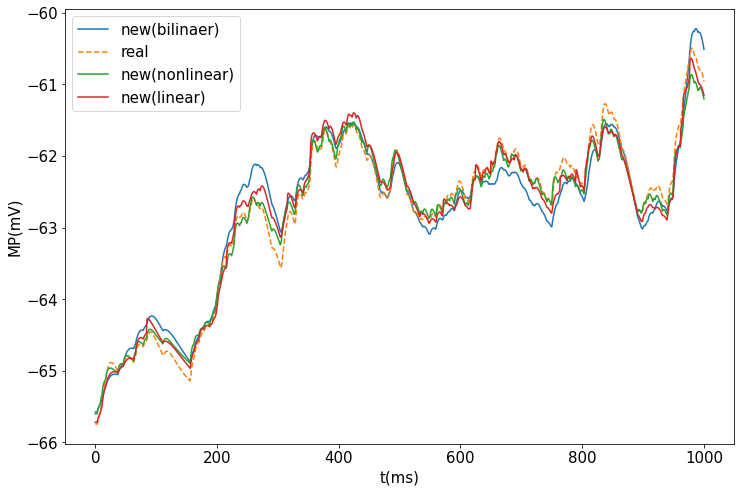

In [82]:
Vars_old = res.x
plt.figure(figsize=(12,8))
y = model(X_test_array[2], Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
y2 = model_non2(X_test_array[2], Vars_non[0:9], Vars_non[9:18], Vars_non[18:27], Vars_non[27], Vars_non[28], Vars_non[29])
#y3 = model_non(X_test_array[2], Vars_old[0:9], Vars_old[9:18], Vars_old[18], Vars_old[19], Vars_old[20])
y4 = model_l(X_test_array[2], Vars_l[0:9], Vars_l[9:18], Vars_l[18:27], Vars_l[27])

plt.plot(y*np.std(Y_train)+np.mean(Y_train), label='new(bilinaer)')
plt.plot(Y_test_std[2]*np.std(Y_train)+np.mean(Y_train), '--', label='real')
plt.plot(y2*np.std(Y_train)+np.mean(Y_train), label='new(nonlinear)')
#plt.plot(y3*np.std(Y_train)+np.mean(Y_train), label='old(nonlinear)')
plt.plot(y4*np.std(Y_train)+np.mean(Y_train), label='new(linear)')

plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.legend()
#plt.savefig('figure/compare_biexp_passive.png')

In [83]:
def variance_explained(x, y):
    err = np.sum(np.square(x - y))
    var = np.sum(np.square(y - np.mean(y)))
    return 1 - err / var

In [34]:
Vars_old = res.x

In [48]:
test_ve_old[2]

0.9150801402204524

Text(0, 0.5, 'variance explained')

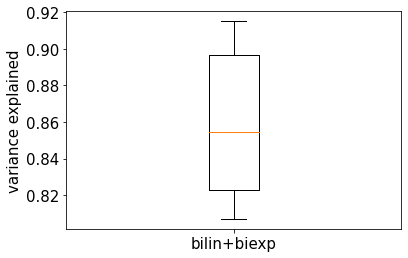

In [30]:
Vars_non = res.x
test_pred_non = hlm_old(X_test_array, Vars_non[0:9], Vars_non[9:18], Vars_non[18:27], Vars_non[27], Vars_non[28], Vars_non[29])
test_ve_non = np.empty(X_test_array.shape[0])
test_ve_b = np.empty(X_test_array.shape[0])
for i in range(len(test_ve_b)):
    #test_ve_b[i] = variance_explained(test_pred_b[i], Y_test_std[i])
    test_ve_non[i] = variance_explained(test_pred_non[i], Y_test_std[i])
p = ['bilin+biexp']
plt.boxplot([test_ve_non],showfliers=True,labels=p)
#plt.ylim(0.95, 1)
plt.ylabel('variance explained')

In [87]:
np.argmax(test_ve_b)

2

Text(0, 0.5, 'variance explained')

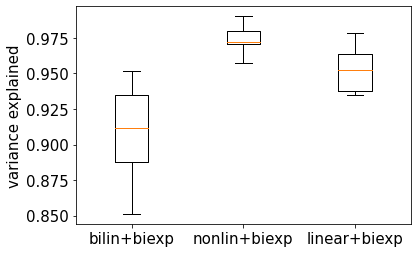

In [86]:
test_pred_b = hlm(X_test_array, Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
#test_pred_old = hlm_non(X_test_array, Vars_old[0:9], Vars_old[9:18], Vars_old[18], Vars_old[19], Vars_old[20])
test_pred_non = hlm_non2(X_test_array, Vars_non[0:9], Vars_non[9:18], Vars_non[18:27], Vars_non[27], Vars_non[28], Vars_non[29])
test_pred_l = hlm_l(X_test_array, Vars_l[0:9], Vars_l[9:18], Vars_l[18:27], Vars_l[27])

test_ve_b = np.empty(X_test_array.shape[0])
test_ve_non = np.empty(X_test_array.shape[0])
#test_ve_old = np.empty(X_test_array.shape[0])
test_ve_l = np.empty(X_test_array.shape[0])

for i in range(len(test_ve_b)):
    test_ve_b[i] = variance_explained(test_pred_b[i], Y_test_std[i])
    test_ve_non[i] = variance_explained(test_pred_non[i], Y_test_std[i])
    #test_ve_old[i] = variance_explained(test_pred_old[i], Y_test_std[i])
    test_ve_l[i] = variance_explained(test_pred_l[i], Y_test_std[i])
p = ['bilin+biexp', 'nonlin+biexp', 'linear+biexp']
plt.boxplot([test_ve_b, test_ve_non, test_ve_l],showfliers=False,labels=p)
#plt.ylim(0.9, 1)
plt.ylabel('variance explained')
#plt.savefig('figure/boxplot_compare_biexp_passive',bbox_inches='tight')